# Model inference benchmarking

In [1]:
import gc
import time

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

import matplotlib.pyplot as plt

from simulator.game.connect import Config, State, Action  # pyright: ignore[reportMissingModuleSource]

from alphazero import RandomPredictor, Search
from alphazero.model.connect import Model, states_to_tensor

In [2]:
# The whole notebook will use Connect4
config = Config(6, 7, 4)

In [3]:
def measure(batch_size, device, num_repeats):
    # Create default-initialized model; the actual weights do not matter here
    # Note: model is assumed to already be on the device
    model = Model(config.width).to(device)

    # Inference time is independent of the actual game state
    # Note: encoding time is not measured here
    state = config.sample_initial_state()
    states = [state] * batch_size
    x = states_to_tensor(states)

    # As done by `timeit`, disable garbage collection during measurement
    gc.disable()

    # Perform inference multiple times, for robust estimate
    # Note: transfer between devices is included, and this also enforces synchronization!
    start_time = time.perf_counter()
    for _ in range(num_repeats):
        with torch.no_grad():
            policy_logits, value_logits = model(x.to(device))
        policy_logits = policy_logits.cpu().numpy()
        value_logits = value_logits.cpu().numpy()
    end_time = time.perf_counter()
    gc.enable()
    duration = (end_time - start_time) / num_repeats
    return duration

In [4]:
# Let us pick a few batch sizes
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [5]:
# Use a few devices
assert torch.backends.mps.is_available()
devices = {
    "cpu": torch.device("cpu"),
    "mps": torch.device("mps"),
}

In [6]:
# Do measurements
df = pd.DataFrame(index=batch_sizes, columns=devices.keys())
for device_name, device in devices.items():
    for batch_size in tqdm(batch_sizes, desc=device_name):
        duration = measure(batch_size, device, num_repeats=1000)
        df.loc[batch_size, device_name] = duration

mps: 100%|██████████| 11/11 [00:25<00:00,  2.28s/it]


In [7]:
# Overall, inference is at millisecond-level
df * 1e3

,cpu,mps
1,0.119621,1.02526
2,0.237324,0.974136
4,0.259396,1.34637
8,0.34102,1.090783
16,1.528647,1.179443
32,2.092899,1.326052
64,3.571616,1.259309
128,5.627611,1.696019
256,8.238137,2.602917
512,15.643095,4.46269


In [8]:
# Of course, batching does reduce the per-state cost, reaching tens of microseconds
df.div(df.index, axis=0) * 1e6

,cpu,mps
1,119.621083,1025.25975
2,118.661771,487.068146
4,64.849031,336.592562
8,42.627547,136.347906
16,95.540469,73.715177
32,65.403079,41.439124
64,55.806496,19.676705
128,43.965714,13.250145
256,32.180223,10.167646
512,30.55292,8.716191


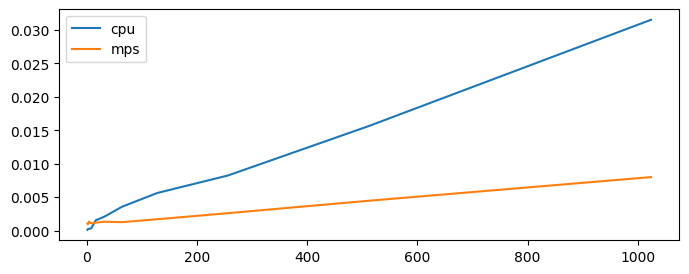

In [9]:
ax = df.plot(figsize=(8, 3))
# ax.set_xscale("log")
# ax.set_yscale("log")

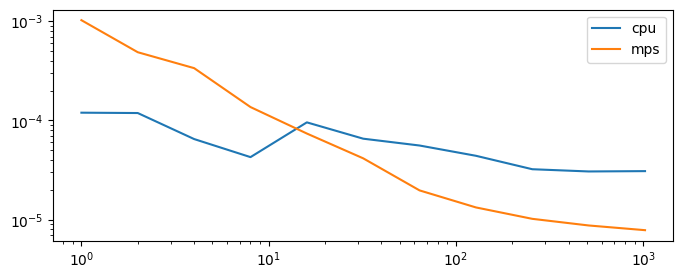

In [10]:
ax = df.div(df.index, axis=0).plot(figsize=(8, 3))
ax.set_xscale("log")
ax.set_yscale("log")

In [11]:
# Now, let us look at the remaining part of the inference process, which is not batched
state = config.sample_initial_state()

In [12]:
# Use a dummy inference that has negligible cost
predictor = RandomPredictor()

In [13]:
# Again, doing measurement manually, `timeit` does not support asyncio
num_repeats = 1000
gc.disable()
start_time = time.perf_counter()
for _ in range(num_repeats):
    search = Search(state, predictor, c_puct=1.0)
    for _ in range(1000):
        await search.step()
end_time = time.perf_counter()
gc.enable()
duration = (end_time - start_time) / num_repeats
duration

0.03476084891706705

In [14]:
# Therefore, for 1000 MCTS iterations on a single state, we roughly need:
#  - 30ms in pure Python, for the tree traversal (incl. state and action computations)
#  - 2000ms on MPS-side, for neural network inference itself (incl. synchronization and trandfer time)
# However, if we exploit batching properly, the neural network can be amortized.
# Starting a few hundreds of samples per batch, Python code cannot keep up and this would lead to GPU starvation.